In [1]:
import numpy as np
import networkx as nx
import matplotlib
from scipy.stats import multivariate_normal
import pdb
%matplotlib inline

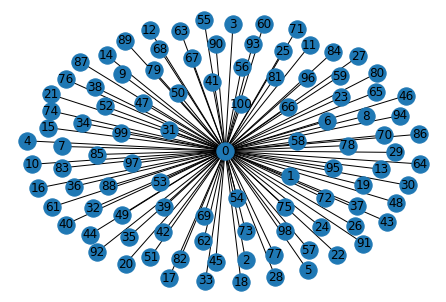

In [4]:
T = nx.balanced_tree(100, 1)
nx.draw(T, with_labels=True)

# Balanced Trees

In [5]:
depths = list(range(2,5))
degrees = list(range(2, 5))
#graphs
G = {}
for d1 in degrees:
    G[d1] = {}
    for d2 in depths:
        G[d1][d2] = nx.balanced_tree(d1, d2)
G

{2: {2: <networkx.classes.graph.Graph at 0x1a235e5690>,
  3: <networkx.classes.graph.Graph at 0x1a235e5f10>,
  4: <networkx.classes.graph.Graph at 0x1a235e5d90>},
 3: {2: <networkx.classes.graph.Graph at 0x1a235e5990>,
  3: <networkx.classes.graph.Graph at 0x1a235e56d0>,
  4: <networkx.classes.graph.Graph at 0x1a235e5f90>},
 4: {2: <networkx.classes.graph.Graph at 0x1a23367690>,
  3: <networkx.classes.graph.Graph at 0x1a23367950>,
  4: <networkx.classes.graph.Graph at 0x1a23367050>}}

Visualizing the trees

degree: 2, depth: 2

degree: 2, depth: 3

degree: 2, depth: 4

degree: 3, depth: 2

degree: 3, depth: 3

degree: 3, depth: 4

degree: 4, depth: 2

degree: 4, depth: 3

degree: 4, depth: 4



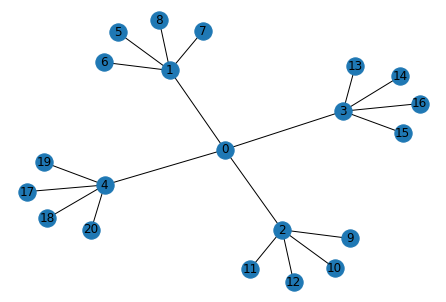

In [6]:
for g in G:
    for k in G[g]:
        print("degree: {}, depth: {}".format(g, k))
        #nx.draw(G[g][k], with_labels=True)
        print("")
        
nx.draw(G[4][2], with_labels=True)

In [8]:
def adjacency_matrix_to_parents(A):
    parents = {}
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if j == i:
                continue
            else:
                #pdb.set_trace()
                if A[i, j] == 1 and A[j, i] == 1 and (j+1 not in list(parents.values())):
                    parents[j+1] = i + 1
    return parents

In [20]:
parents[2][3]

{2: 1,
 3: 1,
 4: 2,
 5: 2,
 6: 3,
 7: 3,
 8: 4,
 9: 4,
 10: 5,
 11: 5,
 12: 6,
 13: 6,
 14: 7,
 15: 7}

In [21]:
# latent space dimension
d = 2
parents = {}
n_leaves = {}
n_nodes = {}
covs = {}
for g in G:
    parents[g], n_leaves[g], n_nodes[g], covs[g] = {}, {}, {}, {}
    for k in G[g]:
        print("degree: {}, depth: {}".format(g, k))
        A = nx.adjacency_matrix(G[g][k])
        parents[g][k] = adjacency_matrix_to_parents(A)
        n_nodes[g][k] = len(parents[g][k].keys()) + 1
        if g==1:
            n_leaves[g][k] = len([node for node in G[g][k].nodes() if G[g][k].degree(node)==1]) - 1
        else:
            n_leaves[g][k] = len([node for node in G[g][k].nodes() if G[g][k].degree(node)==1])
        
        # introduce wieghts
        for node in G[g][k]:
            for n in G[g][k][node]:
                G[g][k][node][n]["weight"] = 1.0
                
        # add prior node
        G[g][k].add_node(n_nodes[g][k])
        G[g][k].add_edge(0, n_nodes[g][k], weight=1.0)
        
        # build covariance matrix
        inverse_covariance = np.zeros((n_nodes[g][k] * d, n_nodes[g][k] * d))
        for i in range(1, n_nodes[g][k]):
            pi_ind = parents[g][k][i + 1] - 1
            #print(i, i*d, (i+1)*d, pi_ind*d, (pi_ind+1)*d)
            inverse_covariance[i * d: (i + 1) * d, i * d: (i + 1) * d] += np.identity(d)
            inverse_covariance[pi_ind * d: (pi_ind + 1) * d, pi_ind * d: (pi_ind + 1) * d] += np.identity(d)
            inverse_covariance[pi_ind * d: (pi_ind + 1) * d, i * d: (i + 1) * d] += - np.identity(d)
            inverse_covariance[i * d: (i + 1) * d, pi_ind * d: (pi_ind + 1) * d] += - np.identity(d)
        # root
        inverse_covariance[0:d, 0:d] += np.identity(d)
        covs[g][k] = np.linalg.inv(inverse_covariance)
        print("")

degree: 2, depth: 2

degree: 2, depth: 3

degree: 2, depth: 4

degree: 3, depth: 2

degree: 3, depth: 3

degree: 3, depth: 4

degree: 4, depth: 2

degree: 4, depth: 3

degree: 4, depth: 4



In [22]:
#inverse_covariance_bis = np.zeros((n_nodes * d, n_nodes * d))
#for  i in range(2, n_nodes+1):     #in range(1, n_nodes - 1):
    #i = i - 1
    #pi_ind = parents[i + 1] - 1
    #print(i, i*d, (i+1)*d, pi_ind*d, (pi_ind+1)*d)
    #inverse_covariance_bis[i * d: (i + 1) * d, i * d: (i + 1) * d] += np.identity(d)
    #inverse_covariance_bis[pi_ind * d: (pi_ind + 1) * d, pi_ind * d: (pi_ind + 1) * d] += np.identity(d)
    #inverse_covariance_bis[pi_ind * d: (pi_ind + 1) * d, i * d: (i + 1) * d] += - np.identity(d)
    #inverse_covariance_bis[i * d: (i + 1) * d, pi_ind * d: (pi_ind + 1) * d] += - np.identity(d)
#inverse_covariance_bis[0:d, 0:d] += np.identity(d)

#full_covariance = np.linalg.inv(inverse_covariance)

## 2. Exact computations via message passing
Initialize the network with messages

In [23]:
import copy

def initialize_messages(G, d, evidence, prior_node):
    ev = copy.deepcopy(evidence)
    dic_nu = {}
    dic_mu = {}
    dic_log_z = {}
    for i, x in enumerate(ev):
        dic_nu[i] = 0.0
        dic_log_z[i] = 0.0
        dic_mu[i] = x
    #pdb.set_trace()
    dic_nu[prior_node] = 0.0
    dic_mu[prior_node] = np.zeros(d)
    dic_log_z[prior_node] = 0.0
    nx.set_node_attributes(G, dic_nu, 'nu')
    nx.set_node_attributes(G, dic_mu, 'mu')
    nx.set_node_attributes(G, dic_log_z, 'log_z')

In [24]:
def initialize_visit(G, prior_node):
    dic_visited = {}
    for node in G:
        dic_visited[node] = False
    nx.set_node_attributes(G, dic_visited, 'visited')

In [25]:
def product_without(L, exclude):
    """
    L: list of elements
    exclude: list of the elements indices to exlucde
    
    returns: product of all desired array elements
    """
    prod = 1
    for idx, x in enumerate(L):
        if idx in exclude:
            continue
        else:
            prod *= x
    return prod   

In [26]:
def perform_message_passing(T, root_node, prior_node, include_prior):
    # print(root_node)
    # flag the node as visited
    T.nodes[root_node]["visited"] = True
            
    incoming_messages = []
    # get list of neighbors that are not visited yet
    for node in T.neighbors(root_node):
        if not T.nodes[node]["visited"] and (node != prior_node  or (node == prior_node and include_prior) ):
            perform_message_passing(T, node, prior_node, include_prior)
            incoming_messages.append(node)
            
    # collect and return 
    if len(incoming_messages) == 0:
        # nothing to do. This happens on the leaves
        return None
    
    elif len(incoming_messages) == 1:
        # this happens when passing through the root
        k = incoming_messages[0]
        T.nodes[root_node]["nu"] = T.nodes[k]["nu"] + T[root_node][k]["weight"]
        T.nodes[root_node]["mu"] += T.nodes[k]["mu"]
        T.nodes[root_node]["log_z"] = 0.0 
    
    elif len(incoming_messages) >= 2:
        #pdb.set_trace()
        # children node i = incoming_messages[i]
        # n: number of children
        n = len(incoming_messages)
        
        #we will keep track of mean and variances of the children nodes in 2 lists
        children_nu = [0.0]*n
        children_mu = [0.0]*n
        
        #updates: mean and variance
        
        #lambda: used later for the normalizing constant
        for i in range(n):
            k = incoming_messages[i]
            children_nu[i] = T.nodes[k]["nu"] + T[root_node][k]["weight"]
            T.nodes[root_node]["nu"] += 1. / children_nu[i]
            children_mu[i] = T.nodes[k]["mu"] / children_nu[i]
            T.nodes[root_node]["mu"] += children_mu[i]
            
            
        T.nodes[root_node]["nu"] = 1. / T.nodes[root_node]["nu"]
        T.nodes[root_node]["mu"] *= T.nodes[root_node]["nu"]
        
        #find t
        t = 0
        for excluded_idx in range(n):
            prod = product_without(children_nu, [excluded_idx])
            t += prod
            
        #normalizing constant
            Z_1 = -0.5 * (n - 1) * d * np.log(2 * np.pi)
            Z_2 = -0.5 * d * np.log(t)
            Z_3 = 0
        
        #nested for loop
        for j in range(n):
            for h in range(n):
                if h == j:
                    continue
                else:
                    prod_2 = product_without(children_nu, [j, h])
            k = incoming_messages[h]
            l = incoming_messages[j]
            Z_3 += prod_2 * np.sum((T.nodes[k]["mu"] - T.nodes[l]["mu"]) ** 2)
        Z_3 *= -0.5 / t
        
        T.nodes[root_node]["log_z"] = Z_1 + Z_2 + Z_3

In [27]:
def aggregate_messages_into_leaves_likelihood(T, root, add_prior):
    res = 0
    
    # agg Z messages
    for node in T.nodes():
        res += T.nodes[node]["log_z"]
        
    if add_prior:
        # add prior
        nu_inc = 1 + T.nodes[root]["nu"]
        res += - 0.5 * np.sum(T.nodes[root]["mu"] ** 2) / nu_inc - d * 0.5 * np.log(2 * np.pi * nu_inc)
    
    return res

### 2.a case for leaves marginals (for VI bound)
the task here is to compute  $\log p(𝑥1,𝑥2,𝑥3,𝑥4,x5,x6,x7)$ . This can be done quickly via marginalization of the Gaussian vector

In [28]:
for g in G:
    for k in G[g]:    
        evidence = [np.array([1.0] * d)]*n_leaves[g][k]

        # marginalization of covariance
        leaves_covariance = covs[g][k][(n_nodes[g][k] - n_leaves[g][k]) * d:,
                                            (n_nodes[g][k] - n_leaves[g][k]) * d:]
        
        leaves_mean = np.array([0.0] * n_leaves[g][k] * d)

        # message passing: call from the root
        root = 0
        prior_node = n_nodes[g][k]
        tree = G[g][k]
        collect_prior_node = False

        initialize_visit(tree, prior_node)
        initialize_messages(tree,
                            d,
                            [np.array([0.0]*d) for i in range(n_nodes[g][k] - n_leaves[g][k])] + evidence,
                            prior_node)
        
        perform_message_passing(tree, root, prior_node, collect_prior_node)

        import time

        t = time.time()
        print(">>>> Balanced tree of degree {} and depth {}".format(g, k))
        print("")
        x =  multivariate_normal.logpdf(np.hstack(evidence), leaves_mean, leaves_covariance)
        print("Gaussian marginalization output O(n^3d^3): ",
             x)
        print("scipy: " + str(time.time() - t) + "seconds")

        print("")

        t = time.time()
        y = aggregate_messages_into_leaves_likelihood(tree, root, add_prior=True)
        print("Message passing output O(nd): ", 
              y) 
        print("message passing: " + str(time.time() - t) + "seconds")
        print("")
        print("Error: {}".format(np.abs(x-y)))
        print("")
        print("-------------------------------------------------")
        print("")
        print("")

>>>> Balanced tree of degree 2 and depth 2

Gaussian marginalization output O(n^3d^3):  -13.29058271370888
scipy: 0.001203775405883789seconds

Message passing output O(nd):  -13.290582713708883
message passing: 0.00017714500427246094seconds

Error: 3.552713678800501e-15

-------------------------------------------------


>>>> Balanced tree of degree 2 and depth 3

Gaussian marginalization output O(n^3d^3):  -24.456888959252137
scipy: 0.004419803619384766seconds

Message passing output O(nd):  -24.456888959252144
message passing: 0.00017070770263671875seconds

Error: 7.105427357601002e-15

-------------------------------------------------


>>>> Balanced tree of degree 2 and depth 4

Gaussian marginalization output O(n^3d^3):  -46.7407842228115
scipy: 0.0034139156341552734seconds

Message passing output O(nd):  -46.74078422281149
message passing: 0.00015211105346679688seconds

Error: 7.105427357601002e-15

-------------------------------------------------


>>>> Balanced tree of degree

## Binomial trees

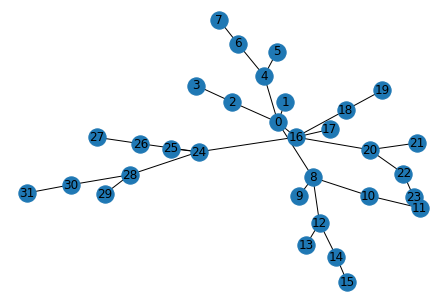

In [29]:
T = nx.binomial_tree(5)
nx.draw(T, with_labels=True)

In [30]:
orders = list(range(2, 5))
#graphs
B = {}
for o in orders:
    B[o] = nx.binomial_tree(o)
B

{2: <networkx.classes.graph.Graph at 0x1a2b30c750>,
 3: <networkx.classes.graph.Graph at 0x1a2b30c350>,
 4: <networkx.classes.graph.Graph at 0x1a2b30cc90>}

Visualizing the tree

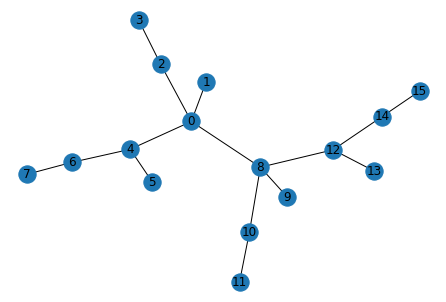

In [31]:
nx.draw(B[4], with_labels=True)

In [32]:
# latent space dimension
d = 2
parents2 = {}
n_leaves2 = {}
n_nodes2 = {}
leaves = {}
covs2 = {}
my_parents = {2:1, 3:1, 5:1, 9:1, 4:3, 6:5, 7:5, 8:7, 10:9, 11:9, 13:9, 12:11, 14:13, 15:13, 16:15}
for o in B:
    #print("order: {}".format(o))
    A = nx.adjacency_matrix(B[o])
    if o == 4:
        parents2[o] = my_parents
    else:
        parents2[o] = adjacency_matrix_to_parents(A)
    
    #pdb.set_trace()
    
    n_nodes2[o] = len(parents2[o].keys()) + 1
    # Get index of leaves
    leaves[o] = [node for node in [n for n in B[o].nodes() if B[o].degree(n) == 1] if (node != 0)]
    
    if o == 1:
        n_leaves2[o] = len(leaves[o]) - 1
    else:
        n_leaves2[o] = len(leaves[o])
    
    # introduce wieghts
    for node in B[o]:
        for n in B[o][node]:
            B[o][node][n]["weight"] = 1.0

    # build covariance matrix
    inverse_covariance = np.zeros((n_nodes2[o] * d, n_nodes2[o] * d))
    for i in parents2[o]:
        i = i - 1
        pi_ind = parents2[o][i + 1] - 1
        #print(i, pi_ind)
        inverse_covariance[i * d: (i + 1) * d, i * d: (i + 1) * d] += np.identity(d)
        inverse_covariance[pi_ind * d: (pi_ind + 1) * d, pi_ind * d: (pi_ind + 1) * d] += np.identity(d)
        inverse_covariance[pi_ind * d: (pi_ind + 1) * d, i * d: (i + 1) * d] += - np.identity(d)
        inverse_covariance[i * d: (i + 1) * d, pi_ind * d: (pi_ind + 1) * d] += - np.identity(d)
    # root
    inverse_covariance[0:d, 0:d] += np.identity(d)
    covs2[o] = np.linalg.inv(inverse_covariance)
    
    #pdb.set_trace()
    
    # add prior node
    B[o].add_node(n_nodes2[o])
    B[o].add_edge(0, n_nodes2[o], weight = 1.0)
    #print("")

### 2.a case for leaves marginals (for VI bound)
the task here is to compute  $\log p(𝑥1,𝑥2,𝑥3,𝑥4,x5,x6,x7)$ . This can be done quickly via marginalization of the Gaussian vector

In [33]:
for o in B:  
    evidence = [None] * n_nodes2[o]
    for i in range(n_nodes2[o]):
        if i in leaves[o]:
            evidence[i] =  np.array([1.0] * d)
        else:
            evidence[i] = np.array([0.0] * d)        
    
    evidence_leaves = np.hstack([np.array([1.0] * d)] * n_leaves2[o])

    # marginalization of covariance
    to_delete_idx = [i for i in B[o].nodes() if i not in leaves[o]][:-1]
    to_delete = []
    for k in to_delete_idx:
        to_delete += [k * d , k * d + 1]
    
    x = np.delete(covs2[o], to_delete, 0)
    leaves_covariance = np.delete(x, to_delete, 1)
    
    # mean of leaves
    leaves_mean = np.array([0.0] * n_leaves2[o] * d)
    
    import pdb
    #pdb.set_trace()
    
    # message passing: call from the root
    root = 0
    prior_node = n_nodes2[o]
    collect_prior_node = False

    initialize_visit(B[o], prior_node)
    initialize_messages(B[o],
                        d,
                        evidence,
                        prior_node)

    #pdb.set_trace()
    
    perform_message_passing(B[o], root, prior_node, collect_prior_node)

    import time

    t = time.time()
    print(">>>> Binomial tree of order {}".format(o))
    print("")
    x =  multivariate_normal.logpdf(evidence_leaves,
                                    leaves_mean,
                                    leaves_covariance)
    print("Gaussian marginalization output O(n^3d^3): ",
         x)
    print("scipy: " + str(time.time() - t) + "seconds")

    print("")

    t = time.time()
    y = aggregate_messages_into_leaves_likelihood(B[o],
                                                  root,
                                                  add_prior=True)
    print("Message passing output O(nd): ", 
          y) 
    print("message passing: " + str(time.time() - t) + "seconds")
    print("")
    print("Error: {}".format(np.abs(x - y)))
    print("")
    print("-------------------------------------------------")
    print("")
    print("")

>>>> Binomial tree of order 2

Gaussian marginalization output O(n^3d^3):  -5.885192045252792
scipy: 0.0013060569763183594seconds

Message passing output O(nd):  -5.885192045252792
message passing: 9.012222290039062e-05seconds

Error: 0.0

-------------------------------------------------


>>>> Binomial tree of order 3

Gaussian marginalization output O(n^3d^3):  -11.462914824961238
scipy: 0.002985239028930664seconds

Message passing output O(nd):  -11.462914824961238
message passing: 8.797645568847656e-05seconds

Error: 0.0

-------------------------------------------------


>>>> Binomial tree of order 4

Gaussian marginalization output O(n^3d^3):  -22.50389889572645
scipy: 0.0028460025787353516seconds

Message passing output O(nd):  -22.50389889572645
message passing: 0.00016570091247558594seconds

Error: 0.0

-------------------------------------------------




In [ ]:
for k in range(n_nodes2[4]):
    print(k, B[o].nodes[k])